In [1]:
# ML_in_Finance-Deep-Factor-Models
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6.9 and the following packages:
# numpy=1.18.1, keras=2.3.1, tensorflow=2.0.0, matplotlib=3.1.3, statsmodels=0.10.1, scikit-learn=0.22.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., I. Halperin and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# Overview

The purpose of this notebook is to demonstrate the application of deep learning to fundamental factor modeling. The outputs are monthly excess returns, the inputs are fundamental factor loadings (BARRA style). The data provided has already been normalized. 

The notebook describes the data loading, training using walk-forward optimization, performance evaluation and comparison with ordinary least squares (OLS) regression. The toy dataset consists of 6 fundamental factors for 218 stocks over a 100 month period starting in February 2008. 

See the description of the smaller dataset described in Section 6.2 of Chpt 5. See Table 5.4 for a description of the factors.

In [10]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import timeit
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta

%matplotlib inline 

### Define a deep neural network (with $L-1$ hidden layers) model in Keras

We define functions for the creation, training, and optional parameter tuning of the model. 

In [11]:
def NN(n_inputs, n_units=10, dropout=0.1, l1_reg=0.001, activation='relu', L=2):
    # L>0 is the number of hidden layers
    
    model = Sequential()
    model.add(Dense(units=n_units, input_dim=n_inputs, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
    model.add(Dropout(dropout))
    for i in range (0, L-1):
        model.add(Dense(units=n_units, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [12]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

This function selects the best-performing combination of parameter values in `param_grid` cross-validated over `cv` folds

In [6]:
def parameter_tuning(X, y, cv=3, n_epochs=100, n_batch=10, seed=7):
    param_grid = dict(n_inputs=[X.shape[1]], n_units=[10, 20, 50], 
                      l1_reg = [0, 0.0001, 0.001], activation=['relu','tanh']) 
    estimator = KerasRegressor(build_fn=NN, epochs=n_epochs, batch_size=n_batch, verbose=0)   
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                        cv=cv)
    grid_result = grid.fit(X, y, callbacks=[es])
  
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_params_

In [7]:
def training(X, Y, training_dates, L, tune=False):
 
    n_epochs = 100 # maximum number of epochs (to be used with early stopping)
    n_batch = 10 # mini-batch size
    drop_out = 0.0 # level of dropout (set between 0 and 1)
    n_units = 10   
    l1_reg = 0.001 # L_1 regularization parameter
    activation = 'tanh'

    # Create the dictionaries to hold the results
    models = {}
    models['linear'] = []
    models['NN'] = []

    xs = {}
    xs['train'] = []
    xs['test'] = []
    
    ys = {}
    ys['train'] = []
    ys['test'] = []
    
    betas = {}
    betas['NN'] = []
    betas['linear'] = []

    i = 0
    for date in training_dates:
        start_time = timeit.default_timer()  
        print(i, date)
        
        # The following month's date (for the test set)
        date_next = pd.Timestamp(np.datetime64(date)).to_pydatetime() + relativedelta(months=+1)
        date_next = date_next.strftime('%Y-%m-%d')

        # Get the indices of the training and testing points
        train_index = X[X['date'] == date].index
        test_index  = X[X['date'] == date_next].index
        
        # Skip the model if either the train or test sets would be empty
        if len(train_index) == 0 or len(test_index) == 0:
            continue

        # Make the train and test sets
        x_train = X.loc[train_index]
        x_train = x_train.drop("date", axis=1)
        y_train = Y.loc[train_index]
        y_train= y_train.drop("date", axis=1)
        x_test = X.loc[test_index]
        x_test = x_test.drop("date", axis=1)
        y_test = Y.loc[test_index]
        y_test = y_test.drop("date", axis=1)
        
        n_inputs = x_train.shape[1]
        if n_inputs == 0:
            continue
       
        if tune: # Only perform parameter tuning once
            print("Parameter tuning with X-validation...")
            best_params = parameter_tuning(x_train, y_train, 3)
            n_units = best_params['n_units']
            l1_reg = best_params['l1_reg']
            activation = best_params['activation']
            tune = False
        
        # Create and fit the NN for the current training date
        model = NN(n_units=n_units, n_inputs=n_inputs, dropout=drop_out, l1_reg=l1_reg, activation=activation, L=L)
        model.fit(x_train.values, y_train.values, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[es])   
        beta = sensitivities(model, x_train.values, L, activation)   
        
        # Save the results
        models['NN'].append(model)
        betas['NN'].append(beta)
        
        # Fit the OLS regression model for the current date
        x = sm.add_constant(x_train)
        model = sm.OLS(y_train, x).fit()   
        
        # Save the results
        betas['linear'].append(model.params)
        models['linear'].append(model)
        
        # Save the corresponding inputs and outputs for each model 
        xs['train'].append(x_train)
        xs['test'].append(x_test)
        ys['train'].append(y_train)
        ys['test'].append(y_test)

        elapsed = timeit.default_timer() - start_time
        print("Elapsed time: " + str(elapsed) + " (s)")
        i += 1
        
    return models, betas, xs, ys

This function allows us to compute the feature sensitivities in the deep network. It assumes that the activation function is either $tanh$ or $relu$.

In [10]:
def sensitivities(lm, X, L, activation='tanh'):
    W = lm.get_weights()
    M = np.shape(X)[0]
    p = np.shape(X)[1]
    beta = np.zeros((M, p+1))
    B_0 = W[1]
    for i in range (0, L):
        if activation == 'tanh':  
            B_0 = (np.dot(np.transpose(W[2*(i+1)]), np.tanh(B_0)) + W[2*(i+1)+1])
        elif activation == 'relu':
            B_0 = (np.dot(np.transpose(W[2*(i+1)]), np.maximum(B_0, 0)) + W[2*(i+1)+1])
    beta[:, 0] = B_0 # intercept \beta_0 = F_{W,b}(0)
    for i in range(M):
        I1 = np.dot(np.transpose(W[0]), np.transpose(X[i,])) + W[1]
        if activation == 'tanh':
            Z = np.tanh(I1)  
            D = np.diag(1 - Z**2)
        elif activation == 'relu':
            Z = np.maximum(I1, 0)
            D = np.diag(np.sign(Z)) 
        
        for j in range(p):
            J = np.dot(D, W[0][j])       
            for a in range (1, L):
                I = np.dot(np.transpose(W[2*a]), Z) + W[2*a+1] 
                if activation == 'tanh':  
                    Z = np.tanh(I)
                    D = np.diag(1 - Z**2)
                elif activation == 'relu':    
                    Z = np.maximum(I,0)
                    D = np.diag(np.sign(Z)) 
                J = np.dot(np.dot(D, np.transpose(W[2*a])), J)
            beta[i, j+1]=np.dot(np.transpose(W[2*L]), J)
    return beta

Load the data

In [11]:
X = pd.read_csv('../data/X_small.csv') # Factor exposures
Y = pd.read_csv('../data/Y_small.csv') # Asset returns

## Training of models 
A new cross-sectional neural network model is fitted in each period. To evaluate the performance of strategies, we need to train a model for each time step over a historical period. 

In [12]:
training_periods = 100
L = 2 # Number of hidden and output layers
dates = np.unique(X['date'])[0:training_periods] 
models, betas, xs, ys = training(X, Y, dates, L, False) # Set last argument to True to perform cross-validation for parameter tuning

0 2008-02-01
Parameter tuning with X-validation...
Epoch 00024: early stopping
Epoch 00024: early stopping
Epoch 00025: early stopping
Epoch 00019: early stopping
Epoch 00025: early stopping
Epoch 00014: early stopping
Epoch 00005: early stopping
Epoch 00021: early stopping
Epoch 00019: early stopping
Epoch 00015: early stopping
Epoch 00019: early stopping
Epoch 00012: early stopping
Epoch 00019: early stopping
Epoch 00025: early stopping
Epoch 00014: early stopping
Epoch 00025: early stopping
Epoch 00022: early stopping
Epoch 00023: early stopping
Epoch 00015: early stopping
Epoch 00013: early stopping
Epoch 00012: early stopping
Epoch 00024: early stopping
Epoch 00015: early stopping
Epoch 00020: early stopping
Epoch 00027: early stopping
Epoch 00026: early stopping
Epoch 00020: early stopping
Epoch 00025: early stopping
Epoch 00021: early stopping
Epoch 00019: early stopping
Epoch 00009: early stopping
Epoch 00019: early stopping
Epoch 00019: early stopping
Epoch 00013: early stoppi

# Performance evaluation

We note, for this small dataset, that the difference in the MSEs between OLS and neural networks is marginal, however, the L_inf norms are substantially different, indicating the superior ability of the neural network to capture outliers. 

Evaluate MSE of OLS out-of-sample


In [14]:
MSE = 0
y_hat_linear = []
MSE_array_linear = np.array([0]*training_periods, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['test'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    MSE_test_linear = mean_squared_error(y_hat_linear[-1], ys['test'][i].values)
    MSE_array_linear[i] = MSE_test_linear
    MSE += MSE_test_linear
print("MSE: " + str(MSE / training_periods))    

MSE: 0.017511483871247034


Evaluate MSE of OLS in-sample


In [11]:
MSE = 0
MSE_array_linear_in = np.zeros(training_periods).astype('float64')
y_hat_linear_is = []
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    y_hat_linear_is.append(models['linear'][i].predict(x))
    MSE_test_linear = mean_squared_error(y_hat_linear_is[-1], ys['train'][i].values)
    MSE_array_linear_in[i] = MSE_test_linear
    MSE += MSE_test_linear
print("MSE: " + str(MSE / training_periods))    

MSE: 0.004573922402548681


Evaluate $L_{\infty}$ norm of OLS out-of-sample


In [12]:
inf_norm = 0
y_hat_linear = []
inf_norm_linear_out = np.array([0]*training_periods, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['test'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    inf_norm_linear = np.max(np.abs(y_hat_linear[-1] - ys['test'][i].values))
    inf_norm_linear_out[i] = inf_norm_linear
    inf_norm += inf_norm_linear
print("inf-norm: " + str(inf_norm / training_periods))   

inf-norm: 0.5148467207968435


Evaluate $L_{\infty}$ norm of OLS in-sample

In [13]:
inf_norm = 0
y_hat_linear = []
inf_norm_linear_in = np.array([0]*training_periods, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    inf_norm_linear = np.max(np.abs(y_hat_linear[-1] - ys['train'][i].values))
    inf_norm_linear_in[i] = inf_norm_linear
    inf_norm += inf_norm_linear
print("inf-norm: " + str(inf_norm/training_periods)) 

inf-norm: 0.4225199869563092


Evaluate MSE of NN out-of-sample

In [14]:
MSE = 0
MSE_array_NN = np.array([0]*training_periods, dtype='float64')
y_hat_NN = []
for i in range(training_periods):
    y_hat_NN.append(models['NN'][i].predict(xs['test'][i].values))
    MSE_test_NN = mean_squared_error(y_hat_NN[-1], ys['test'][i].values)
    MSE_array_NN[i] = MSE_test_NN
    MSE += MSE_test_NN
print("MSE: " + str(MSE / training_periods))  

MSE: 0.016814848608209615


Evaluate MSE of NN in-sample

In [15]:
MSE = 0
MSE_array_NN_in = np.array([0]*training_periods, dtype='float64')
y_hat_NN_is = []
for i in range(training_periods):
    y_hat_NN_is.append(models['NN'][i].predict(xs['train'][i].values))
    MSE_test_NN = mean_squared_error(y_hat_NN_is[-1], ys['train'][i].values)
    MSE_array_NN_in[i] = MSE_test_NN
    MSE += MSE_test_NN
print("MSE: " + str(MSE / training_periods)) 

MSE: 0.005145836431011453


Evaluate $L_{\infty}$ norm of NN out-of-sample

In [16]:
inf_norm = 0
inf_norm_test_NN = np.array([0]*training_periods, dtype='float64')
y_hat_NN = []
for i in range(training_periods):
    y_hat_NN.append(models['NN'][i].predict(xs['test'][i].values))
    inf_norm_NN = np.max(np.abs(y_hat_NN[-1] - ys['test'][i].values))
    inf_norm_test_NN[i] = inf_norm_NN
    inf_norm += inf_norm_NN
print("inf-norm: " + str(inf_norm/training_periods))  

inf-norm: 0.38414703878522516


Evaluate $L_{\infty}$ of NN in-sample

In [17]:
inf_norm = 0
inf_norm_train_NN = np.array([0]*training_periods, dtype='float64')
y_hat_NN_is = []
for i in range(training_periods):
    y_hat_NN_is.append(models['NN'][i].predict(xs['train'][i].values))
    inf_norm_NN = np.max(np.abs(y_hat_NN_is[-1]- ys['train'][i].values))
    inf_norm_train_NN[i] = inf_norm_NN
    inf_norm += inf_norm_NN
print("inf-norm: " + str(inf_norm/training_periods))  

inf-norm: 0.33293916186696443


### $L_2$ norms

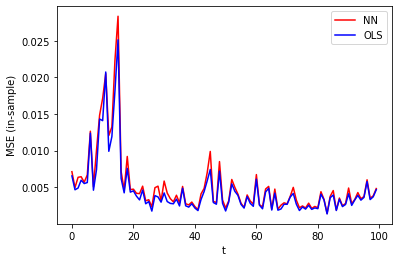

In [18]:
plt.plot(MSE_array_NN_in, color='red', label='NN')
plt.plot(MSE_array_linear_in, color='blue', label='OLS')
plt.ylabel('MSE (in-sample)')
plt.xlabel('t')
plt.legend();

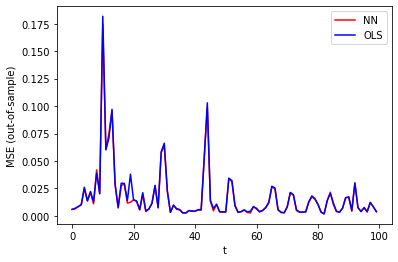

In [19]:
plt.plot(MSE_array_NN, color='red', label='NN')
plt.plot(MSE_array_linear, color='blue', label='OLS')
plt.ylabel('MSE (out-of-sample)')
plt.xlabel('t')
plt.legend();

### $L_{\infty}$ norms 

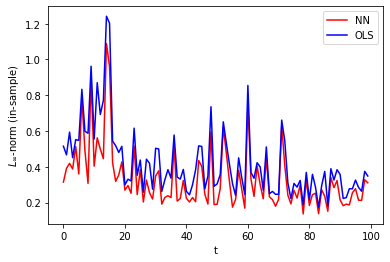

In [20]:
plt.plot(inf_norm_train_NN, color='red', label='NN')
plt.plot(inf_norm_linear_in, color='blue', label='OLS')
plt.ylabel('$L_{\infty}$-norm (in-sample)')
plt.xlabel('t')
plt.legend();

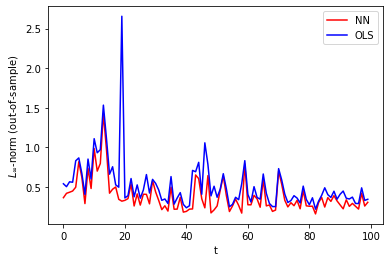

In [21]:
plt.plot(inf_norm_test_NN, color='red', label='NN')
plt.plot(inf_norm_linear_out, color='blue', label='OLS')
plt.ylabel('$L_\infty$-norm (out-of-sample)')
plt.xlabel('t')
plt.legend();

# Sensitivities
Plot the sensitivies of the neural network to the input factors and compare with OLS regression.

In [22]:
betas['NN'][i][0][1:]

array([ 2.9119727e-09,  1.6448817e-08, -3.6024763e-09,  1.4996275e-09,
        9.7157580e-09, -2.9344158e-09], dtype=float32)

In [23]:
n_var = np.shape(betas['NN'][1])[1] - 1

mu = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)
sd = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)
mu_ols = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)

for i in range(training_periods):
    mu[i, :] = np.median(betas['NN'][i], axis=0)[1:]
    sd[i, :] = np.std(betas['NN'][i], axis=0) [1:]
    mu_ols[i, :] = betas['linear'][i][1:]

6


In [24]:
names = ['EV', 'P/B', 'EV/T12M EBITDA', 'P/S' , 'P/E','Log CAP']

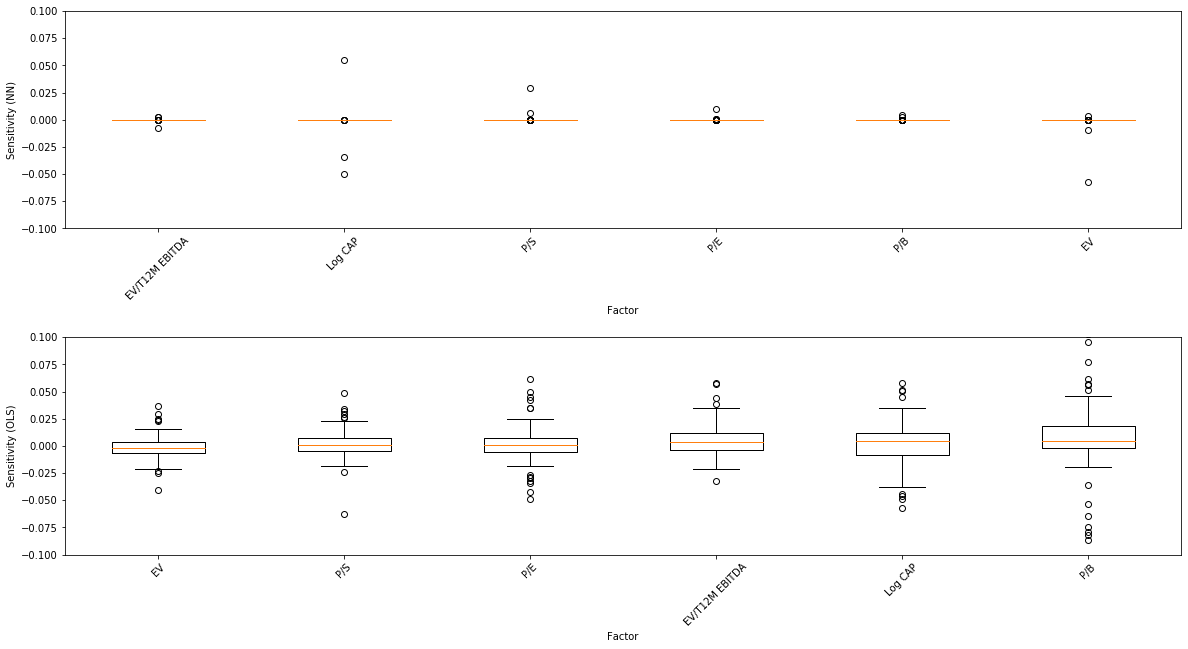

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.7)
%sc = 10000
idx=np.argsort(np.median(mu[:, 0:n_var], axis=0))
axes[0].boxplot(mu[:, idx])       # make your boxplot
axes[0].set_xticklabels(np.array(names)[idx], rotation=45)  
axes[0].set_ylim([-0.1, 0.1])
axes[0].set_ylabel('Sensitivity (NN)')
axes[0].set_xlabel('Factor')
idx = np.argsort(np.median(mu_ols[:, 0:n_var], axis=0))
axes[1].boxplot(mu_ols[:, idx]) 
axes[1].set_ylim([-0.1, 0.1])
axes[1].set_xticklabels(np.array(names)[idx], rotation=45) 

axes[1].set_ylabel('Sensitivity (OLS)')
axes[1].set_xlabel('Factor');

The above sensitivities are sorted in ascending order from left to right. We observe that the OLS regression is much more sensitive to the factors than the NN.